In [1]:
import os
import sys
import random
import itertools
import warnings

import numpy
import numpy as np
import pandas as pd
import scipy
import scipy.stats as spstat

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
import seaborn as sns

# Introduction
We want to create a Gaussian Process Emulator class object that, given a function implementation, shows that it can emulate it. To start, we are interested in simulating the Rosenbrock function.

## Steps towards implementation
1) Create a new class that implements the Rosenbrock function

2a) Use [Latin Hypercube](https://en.wikipedia.org/wiki/Latin_hypercube_sampling) sampling to sample the parameter space

2b) Divide these points between calibration and test points for GP training

3) Create a class for a Gaussian Process Emulator object that takes in a model or simulation (in our case the Rosenbrock function) and a set of training points and uses this to train a GP model. The training points should be obtained from the Latin Hypercube sampling object.

# The Rosenbrock Function
From *A Literature Survey of Benchmark Functions For Global Optimization Problems*:

105. **Rosenbrock Function** (Continuous, Differentiable, Non-Separable, Scalable, Unimodel)

$$f_{105}(x) = \sum_{i=1}^{D-1}[100(x_{i+1} - x_i^2)^2 + (x_i - 1)^2]$$

subject to $-30 \le x_i \le 30$. The global minima is located at $x^* = f(1, ..., 1), f(x^*) = 0$.

In [2]:
#define rosebrock simulation class here
class Rosenbrock():
    """
    A simulation representing the Rosenbrock function.
    
    **Attributes**
        None
    
    **Methods**
    """
    
    def __init__(self, name=u'Rosenbrock Function', a=1, b=100, *args, **kwargs):
        """
        Instantiate the Experiment object

        Args:
            None

        Keyword Args:
            name(str): A name. (Default = 'Rosenbrock Function')
            a(int): subtraction factor in Rosenbrock function
            b(int): multiplication factor in Rosenbrock function
        """
        self.name = name
        self.scaling_factor = 1e3
        self.interval = 0.05
        self.a = a
        self.b = b
        self.function = 'The Rosenbrock Function: f(x, y) = b*(y-x^2)^2 + (x-a)^2'

    def create_grid(self):
        """
        Creates grid from (-3,3) to highlight bottom of function's valley.
        """
        x1 = np.round(np.arange(-2., 2.05, self.interval), 3)
        x2 = np.round(np.arange(-2., 2.05, self.interval), 3)
        x, y = np.array(np.meshgrid(x1, x2))
        self.x = x
        self.y = y
        z = self.b*(y-x**2)**2 + (x-self.a)**2
        self.z = z / self.scaling_factor
    
    def _on_call(self):
        self.create_grid()
    
    def function(self):
        """
        Return a string representation of the Rosenbrock Function.
        """
        return self.function
    
    def _get_minima(self, x, y, z):
        """
        Solution should be at x*=1, y*=1, z*=0, or: x*, y* =1 and f(x*, y*) = 0
        """
        #let's find the global minimum
        zargmin = np.where(z==0)[0][0]
        zmin = z[zargmin, zargmin]
        
        #we expect to see 1, 1
        xmin, ymin = x[zargmin, zargmin], y[zargmin, zargmin]
        
        return xmin, ymin, zmin, zargmin
    
    def global_minima(self, x, y, z):
        """
        Pretty print global minima for x, y, and z axes.
        """
        xmin, ymin, zmin, zargmin = self._get_minima(x, y, z)
        
        print('Min x* found at: {}'.format(float(xmin)))
        print('Min y* found at: {}'.format(float(ymin)))
        print('Min f(x*, y*) found at: {}'.format(zmin))
        
        return [float(xmin), float(ymin), zmin]
    
    def map_point(self, point):
        """
        Maps a point to index space.
        """
        return (point / 4 + 0.5) * len(self.x)
    
    def plot(self, plot_min=True, **kwargs):
        """
        Plots the Rosenbrock function as a 2D surface with or without
        the global minimum.
        """
        xmin, ymin, zmin, zargmin = self._get_minima(self.x, self.y, self.z)
        
        x = list(np.round(np.arange(-2, 2.05, self.interval), 2))
        y = list(np.round(np.arange(-2, 2.05, self.interval), 2))
        X0 = np.where(self.x == xmin)
        Y0 = np.where(self.y == ymin)
        
        ticklabels = np.arange(0, len(x), 4)
        xlabels = [x[idx] for idx in ticklabels]
        ylabels = [y[idx] for idx in ticklabels]
        
        fig, ax = plt.subplots(figsize=(10, 9))
        function = ax.imshow(self.z, cmap='viridis_r')
        fig.colorbar(function)
        
        if(plot_min):
            ax.scatter(X0[1][0], Y0[0][1], s=100, c='lime', alpha=1)
            ax.plot(X0[1], Y0[1], color='r', linestyle='--')
            ax.plot(X0[0], Y0[0], color='r', linestyle='--')
        
        ax.set_xticks(ticklabels)
        ax.set_xticklabels(xlabels)
        
        ax.set_yticks(ticklabels)
        ax.set_yticklabels(ylabels)
        
        ax.set_xlim([len(x)-1, 0])
        ax.set_ylim([len(y)-1, 0])
        
        ax.grid(which='both', color='white', ls = '-.', lw = 0.5)
        
        plt.show()
    
    def plot3d(self, angle=None, plot_min=True, **kwargs):
        """
        Plots the 3D Rosenbrock surface with/without global minimum
        """
        x, y, z = self.x, self.y, self.z
        xmin, ymin, zmin, zargmin = self._get_minima(x, y, z)
        X0 = np.where(x == xmin)
        Y0 = np.where(y == ymin)
        
        plt.style.use('default')
        fig3d = plt.figure(figsize=(10, 9))
        ax3d = fig3d.add_subplot(projection='3d')
        ax3d.plot_surface(x, y, z, alpha=0.7, cmap='viridis_r')
        
        if(plot_min):
            ax3d.scatter(x[zargmin, zargmin], y[zargmin, zargmin], z[zargmin, zargmin], s=100, c='lime', alpha=1)
            ax3d.plot(x[X0], y[X0], color='r', linestyle='--')
            ax3d.plot(x[Y0], y[Y0], color='r', linestyle='--')
        
        ax3d.set_xlabel('x')
        ax3d.set_ylabel('y')
        ax3d.set_zlabel('z')
        fig3d.suptitle('3D Rosenbrock Surface, Before Summation (Scaled by 1/1e3)', fontsize=14)
        
        ax3d.view_init(None, angle)
        fig3d.tight_layout()
        fig3d.subplots_adjust(wspace=0.05)
        
        plt.show()
    
    def plot_train_test(self, train, test, **kwargs):
        """
        Plots the 2D Rosenbrock surface with randomly selected training and test points.
        
        The training and test points should be obtained from a LatinHyperCubeSampler object.
        """
        x = list(np.round(np.arange(-2, 2.05, self.interval), 2))
        y = list(np.round(np.arange(-2, 2.05, self.interval), 2))
        xx, yy = np.meshgrid(x, y)
        
        ticklabels = np.arange(0, len(x), 4)
        xlabels = [x[idx] for idx in ticklabels]
        ylabels = [y[idx] for idx in ticklabels]
        
        fig, ax = plt.subplots(figsize=(10, 9))
        function = ax.imshow(self.z, cmap='viridis_r')
        fig.colorbar(function)
        
        for point in train:
            xpoint, ypoint = (point/4 + 0.5)* len(x)
            ax.scatter(xpoint, ypoint, color='r', s=100)
        
        for point in test:
            xpoint, ypoint = (point/4 + 0.5)* len(x)
            ax.scatter(xpoint, ypoint, color='purple', s=100)
        
        ax.set_xticks(ticklabels)
        ax.set_xticklabels(xlabels)
        
        ax.set_yticks(ticklabels)
        ax.set_yticklabels(ylabels)
       
        ax.set_xlim([len(x)-1, 0])
        ax.set_ylim([len(y)-1, 0])
        
        ax.grid(which='both', color='white', ls = '-.', lw = 0.5)
        plt.show()
    
    def plot_train_test3d(self, train, test, angle=None, **kwargs):
        """
        Plots the 3D Rosenbrock surface with randomly selected training and test points.
        The training and test points should be obtained from a LatinHyperCubeSampler object.
        """
        x, y, z = self.x, self.y, self.z
        
        plt.style.use('default')
        fig3d = plt.figure(figsize=(10, 9))
        ax3d = fig3d.add_subplot(projection='3d')
        
        ax3d.plot_surface(x, y, z, alpha=0.7, cmap='viridis_r')
        
        for point in train:
            xpoint, ypoint = point
            zpoint = (self.b * (ypoint-xpoint**2)**2 + (xpoint-self.a)**2) / self.scaling_factor
            ax3d.scatter(xpoint, ypoint, zpoint, s=100, c='r')
        
        for point in test:
            xpoint, ypoint = point
            zpoint = (self.b * (ypoint-xpoint**2)**2 + (xpoint-self.a)**2) / self.scaling_factor
            ax3d.scatter(xpoint, ypoint, zpoint, s=100, c='purple')
        
        ax3d.set_xlabel('x')
        ax3d.set_ylabel('y')
        ax3d.set_zlabel('z')
        ax3d.set_title('3D Rosenbrock Surface, Before Summation (Scaled by 1/1e3)')
        
        ax3d.view_init(None, angle)
        fig3d.tight_layout()
        fig3d.subplots_adjust(wspace=0.05)
        
        plt.show()
    
    def distplots(self, name, savefig=False):
        """
        Show a histogram of distribution of points for x and y axes,
        as wel as the x-axis * y-axis.
        """
        sns.set(style='white')
        fig, ax = plt.subplots(1, 3, figsize=(15, 5))
        
        sns.distplot(self.x, bins=20, kde=False, label='x', ax=ax[0])
        sns.distplot(self.y, bins=20, kde=False, label='y', color='orange', ax=ax[1])
        sns.distplot(self.x*self.y, bins=20, kde=False, label='x*y', color='green', ax=ax[2])
        
        ax[0].legend()
        ax[1].legend()
        ax[2].legend()
        
        if savefig==True:
            plt.savefig(name, format='pdf', bbox_inches='tight')
        
        plt.show()

In [3]:
rosenbrock = Rosenbrock()
rosenbrock

At this point, the Rosenbrock function object should not have a x, y, or z component because we have not called `_on_call()`.

In [4]:
vars(rosenbrock)

{'name': 'Rosenbrock Function',
 'scaling_factor': 1000.0,
 'interval': 0.05,
 'a': 1,
 'b': 100,
 'function': 'The Rosenbrock Function: f(x, y) = b*(y-x^2)^2 + (x-a)^2'}

In [5]:
rosenbrock._on_call()

In [6]:
print('x' in vars(rosenbrock))
print('y' in vars(rosenbrock))
print('z' in vars(rosenbrock))

True
True
True


In [7]:
print('Minima of function surface:')
minima = rosenbrock.global_minima(rosenbrock.x, rosenbrock.y, rosenbrock.z)

Minima of function surface:
Min x* found at: 1.0
Min y* found at: 1.0
Min f(x*, y*) found at: 0.0


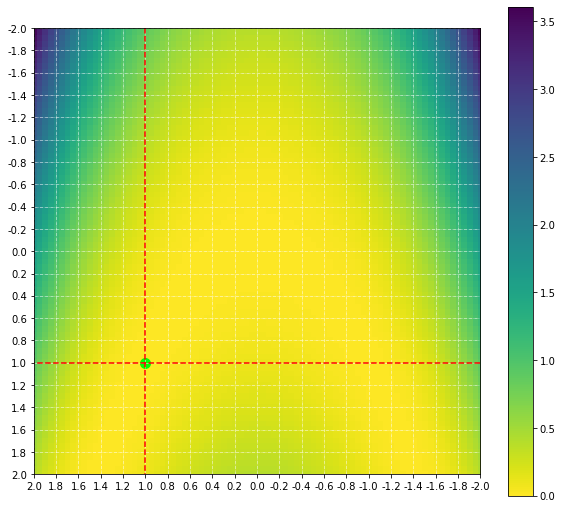

In [8]:
rosenbrock.plot()

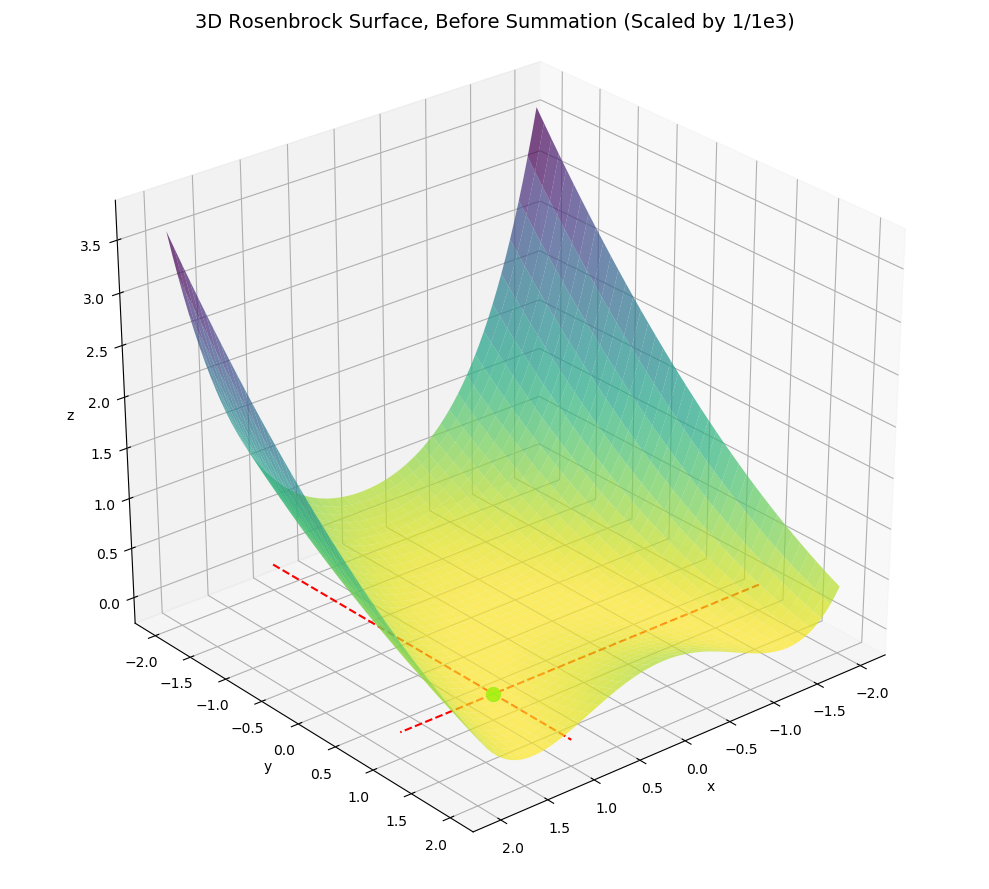

In [9]:
rosenbrock.plot3d(angle=50)

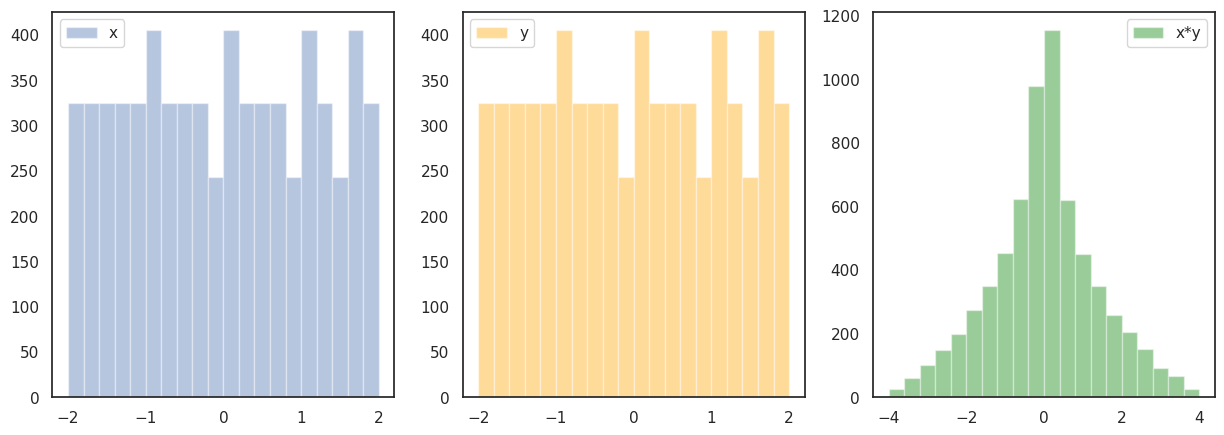

In [10]:
rosenbrock.distplots(name='xy_distplot.pdf')

From the plot above, we see that the x, y variables are equally distributed. We also would have hoped that the x\*y product would be flat, but it seems to follow a Gaussian distribution. We would have hoped that the x, y product was also not Gaussian because we would be biasing our selections to the peak of the Gaussian distribution.

# Latin Hypercube Sampling
From McKay et al (1979):
"Latin Hypercube Sampling. The same reasoning that led to stratified sampling, ensuring that all portions of $S$ were sampled, could lead further. If we wish to ensure also that each of the input variables $X$, has all portions of its distribution represented by input values, we can divide the range of each $X_k$ into $N$ strata of equal marginal probability $\frac{l}{N}$, and sample once from each stratum. Let this sample be $X_{kj} = 1,..., N$. These form the $X_k$ component, $k = 1,..., K$, $X_i, i=1,..., N$. The components of the various $X_k$s are matched at random. This method of selecting input values is an extension of quota sampling, and can be viewed as a K-dimensional extension of Latin square sampling.

One advantage of the Latin hypercube sample appears when the output $Y(t)$ is dominated by only a few of the components of $X$. This method ensures that each of those components is represented in a fully stratified manner, no matter which components might turn out to be important.

We mention here that the $N$ intervals on the range of each component of $X$ combine to form $N^K$ cells which cover the sample space of $X$. These cells, which are labeled by coordinates corresponding to the intervals, are used when finding the properties of the sampling plan."

In [11]:
#define LatinHyperCube object here
class LatinHyperCubeSampler():
    """
    An object that randomly samples the parameter space of a 3D function.
    
    **Attributes**
        None
    
    **Methods**
    """
    def __init__(self, name=u'Latin HyperCube Sampler', rstate=None, *args, **kwargs):
        """
        Instantiate the LatinHyperCubeSampler object
        
        Args:
            None
        
        Keyword Args:
            name(str): A name. (Default = 'Latin HyperCube Sampler')
            rstate(int or numpy.random.mtrand.RandomState): random seed or random state
        """
        self.name = name

        # parse rstate argument
        if(isinstance(rstate, int) or rstate is None):
            self.rstate = np.random.RandomState(seed=rstate)
        elif(isinstance(rstate, numpy.random.mtrand.RandomState)):
            self.rstate = rstate
        else:
            raise TypeError("'rstate' should either be an int or NumPy RandomState object.")
    
    def map_quantiles(self, num):
        """
        Map quantiles 1-4 to their corresponding upper and lower bounds.
        """
        if(type(num.item()) != int):
            raise TypeError('Int value needed, {} value received.'.format(type(num)))

        if(num < 1 or num > 4):
            raise ValueError('Quantile values range from 1-4 inclusive.')

        return (num / 4 - 0.25, num / 4)
    
    def random_uniform(self, lower, upper):
        """
        Generate a random number from a Uniform distribution between
        lower and upper bounds.
        """
        if(type(lower.item()) != int and type(lower.item()) != float):
            raise TypeError('Enter int or float value. {} value received.'.format(type(lower.item())))

        if(type(upper.item()) != int and type(upper.item()) != float):
            raise TypeError('Enter int or float value. {} value received.'.format(type(upper)))

        return spstat.uniform.rvs(loc=lower, scale=upper-lower, random_state=self.rstate)
    
    def sample(self, n, k):
        """
        Randomly selects subset of points from the input parameter space and runs
        a F_UNCLE simulation.
        
        See the R documentation for implementation details:
        https://www.rdocumentation.org/packages/lhs/versions/1.0.2/topics/randomLHS
        """
        if(type(n) != int or type(k) != int):
            raise TypeError('Only enter int values for n and k.')
        
        if(n <= 0 or k <= 0):
            raise ValueError('Both n and k must be positive integers.')
        
        #first, populate an array with the shape (n, k)
        array = np.zeros((n, k))
        
        for column in range(array.shape[1]):
            #randomly generate array length n of quantiles 1-4
            quantiles = self.rstate.randint(1, 5, size=n)

            #map quantiles to upper and lower bounds
            bounds = np.array([self.map_quantiles(value) for value in quantiles])

            #generate random number from uniform distribution between bounds
            random_uniform_array = np.array([self.random_uniform(value[0], value[1]) for value in bounds])
            array[:, column] = random_uniform_array
        
        return array
    
    def train_test_split(self, X, pct):
        """
        Divides randomly selected points from a F_UNCLE simulation between
        calibration and test points for Gaussian Process emulator training
        """
        if(type(X) != numpy.ndarray):
            raise TypeError('Input X should be a numpy array.')
        
        for dim in range(len(X.shape)):
            if(X.shape[dim] <= 0):
                raise ValueError('Dim {} of input array X has shape 0.'.format(dim))
        
        if(type(pct) != float):
            raise TypeError('Please enter a percentage as a float.')
        
        if(pct <= 0 or pct >= 1.0):
            raise Value('pct should be between 0.0 annd 1.0')
        
        idx = int(len(X) * pct)
        train, test = X[:idx, :], X[idx:, :]
        
        return train, test

In [12]:
sampler = LatinHyperCubeSampler()
sampler

In [13]:
sampler.name

'Latin HyperCube Sampler'

In [14]:
print(type(sampler.rstate))

<class 'numpy.random.mtrand.RandomState'>


By default, the randomLHS method will return numbers from [0, 1]. I’m going to rescale them so they go from [-2, 2] to match the bounds on our Rosenbrock function.

In [15]:
X = sampler.sample(100, 2)
X[:, 0] = (X[:, 0] - 0.5) * 4
X[:, 1] = (X[:, 1] - 0.5) * 4

In [16]:
print(X[:5, :])

[[ 0.46481674 -0.88073289]
 [ 1.02188471 -0.58936373]
 [-1.58609624 -0.57214549]
 [-1.42019555 -1.3373443 ]
 [ 1.49274841 -1.26247411]]


In [17]:
print(X.shape)
print(X.min())
print(X.max())

(100, 2)
-1.997621301917318
1.9901687188031603


In [18]:
X_train, X_test = sampler.train_test_split(X, 0.8)

In [19]:
print(X_train.shape)
print(X_test.shape)

(80, 2)
(20, 2)


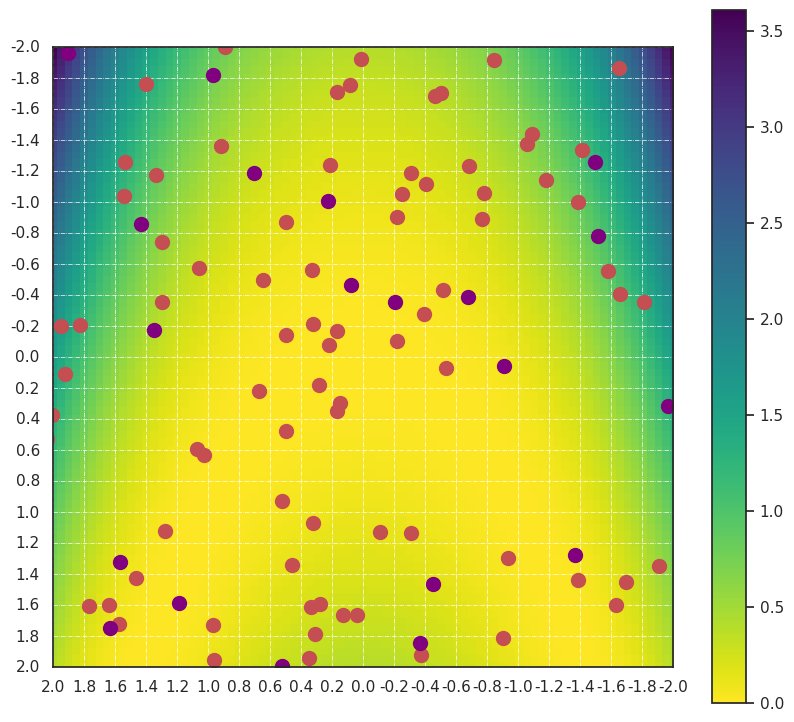

In [20]:
rosenbrock.plot_train_test(X_train, X_test)

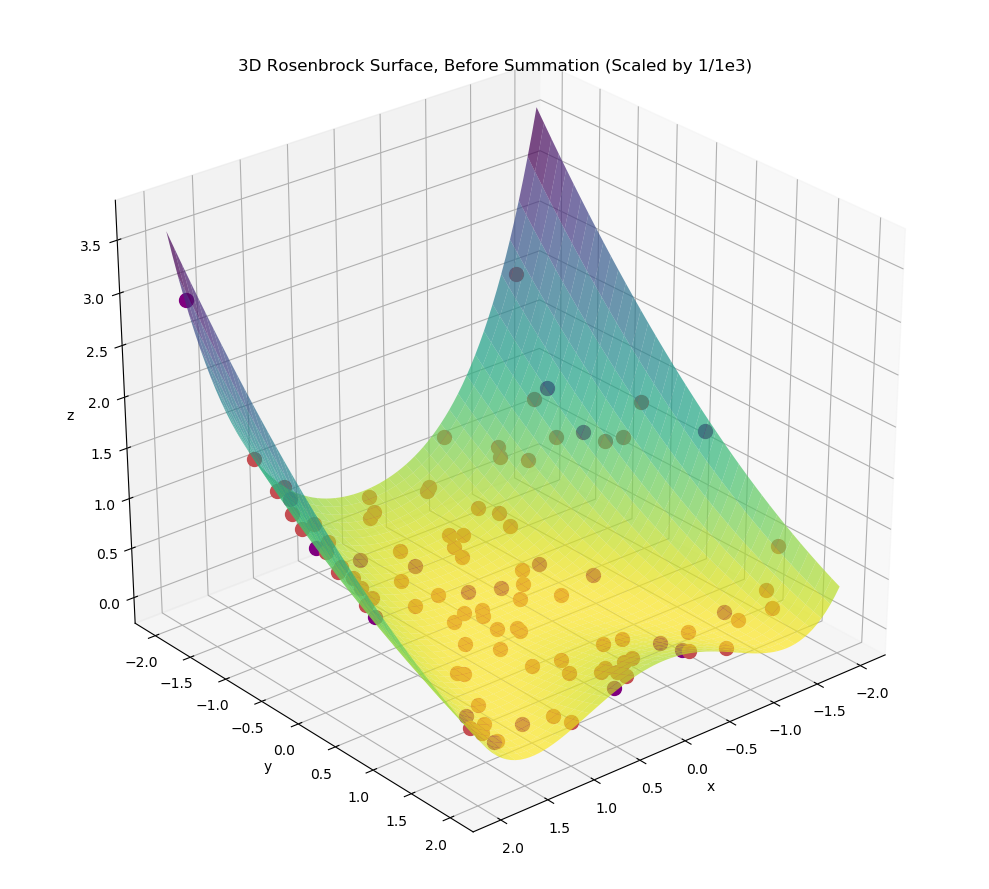

In [21]:
rosenbrock.plot_train_test3d(X_train, X_test, angle=50)

# Gaussian Process Emulation
We have training points that we obtained from the Latin Hypercube sampling object using the Rosenbrock function.

Now, we need to create a kernel function with about the same number of hyper-parameters as the length of the vector and use MCMC to find the set of hyper-parameters that maximizes the posterior probability of observing the training data.

Then we can use this GP function to evaluate the posterior distribution of the parameter vector given experimental observations using a second MCMC simulation. This will hopefully show that the simulation object can emulate the Rosenbrock function (how close are the points + error bars to their actual values).

In [22]:
class Emulator():
    """
    Empty Emulator parent abstract class.
    
    **Attributes**
        None
    
    **Methods**
    """
    def __init__(self, name=u'Emulator', *args, **kwargs):
        """
        Instantiate the Emulator object

        Args:
            None

        Keyword Args:
            name(str): A name. (Default = 'Emulator')
        """
        self.name = name
    
    def train(self, simulation):
        """
        Train the emulator object on a simulation/model object.
        """
        return None

In [23]:
em = Emulator()
print('Class name is: {}'.format(em.name))
print('train() method returns: {}'.format(em.train(rosenbrock)))

Class name is: Emulator
train() method returns: None


In [24]:
#define GPEmulator object here
class GPEmulator(Emulator):
    """
    A Gaussian Process Emulator abstract class.
    
    **Attributes**
        None
    
    **Methods**
    """
    def __init__(self, name=u'Gaussian Process Emulator', rstate=None, *args, **kwargs):
        """
        Instantiate the GPEmulator object

        Args:
            None

        Keyword Args:
            name(str): A name. (Default = 'Gaussian Process Emulator')
            rstate(int or numpy.random.mtrand.RandomState): random seed or random state
        """
        # parse rstate argument
        if(isinstance(rstate, int) or rstate is None):
            self.rstate = np.random.RandomState(seed=rstate)
        elif(isinstance(rstate, numpy.random.mtrand.RandomState)):
            self.rstate = rstate
        else:
            raise TypeError("'rstate' should either be an int or NumPy RandomState object.")
        
        Emulator.__init__(self, name, *args, **kwargs)
    
    def expand_grid(self, x, y):
        """
        Implement a version of R's expand.grid() method. This creates an array
        that pairs each point in x with every point in y.
        
        Parameters:
            x(array): first input array
            y(array): second input array
        
        Returns:
            Array of combination of all points.
        """
        if(type(x) != np.ndarray):
            raise TypeError('Input x should be a numpy array.')
        
        if(type(y) != np.ndarray):
            raise TypeError('Input y should be a numpy array.')
        
        return np.array([(xpoint, ypoint) for xpoint in x for ypoint in y])
    
    def _distance(self, X, Y):
        """
        Evaluates the surrogate model using the points passed in.
        
        Args:
            X(array): (n, k) matrix
            Y(array): (m, k) matrix
        
        Returns:
            D(array): the (n, m) Euclidean distance matrix, a product of X and Y
        """
        D = np.empty((X.shape[0], Y.shape[0]))
        assert len(X.shape) == len(Y.shape)
        
        if len(X.shape) == 1:
            X = X[:, np.newaxis]
            Y = Y[:, np.newaxis]
        
        assert X.shape[1] == Y.shape[1]
        
        for i in range(X.shape[0]):
            for j in range(Y.shape[0]):
                D[i, j] = ((X[i, :] - Y[j, :])**2).sum()
        
        return D
    
    def _mean_fn(self, X):
        """
        Return an array of zeroes from length X.shape[0]
        
        Parameters:
            X: training or testing data of shape (obs, features) = (m, n)
        
        Returns:
            mean: array of zeros of shape (m,)
        """
        mean = np.zeros(len(X))
        return mean
    
    def _diag_epsilon(self, X):
        """
        Return a diagonal matrix with noise on the diagonal and 0's everywhere else.
        
        Parameters:
            X: training or testing data of shape (obs, features) = (m, n)
        
        Returns:
            epsilon: diagonal matrix with noise on the diagonal
        """
        eps = 1.490116e-08
        epsilon = np.diag(np.zeros(X.shape[0]) + eps)
        return epsilon
    
    def _kernel(self, D, noise, *args, **kwargs):
        """
        This returns NotImplemented in the abstract GPEmulator class.
        It should be implemented in child classes.
        
        Returns:
            NotImplemented(Error)
        """
        return NotImplemented
    
    def train(self, simulation, samples, size=1):
        """
        Train the GPEmulator object on a simulation/model object. Builds
        the necessary matrices for evaluating the posterior.
        
        Args:
            simulation(Simulation): a simulation/model object
            samples(array): samples from a LatinHyperCubeSampler class object
            size(int): number of priors to be generated
        """
        print("Training Gaussian Process Emulator...")
        
        self.samples = samples
        self.D = self._distance(self.samples, self.samples)
        epsilon = self._diag_epsilon(self.samples)
        self.Sigma = self._kernel(self.D, epsilon)
        
        self.mu = self._mean_fn(self.samples)
        self.prior = spstat.multivariate_normal.rvs(mean=self.mu, cov=self.Sigma, size=size, random_state=self.rstate)
    
    def _on_call(self, test_points, Y, update=False, *args, **kwargs):
        """
        Evaluates the surrogate model using the points passed in.
        """
        print("Generating posterior estimate...")
        if 'scale' in kwargs:
            self.scale = kwargs['scale']

        if 'length_scale' in kwargs:
            self.length_scale = kwargs['length_scale']

        self.test_points = test_points
        self.Y = Y
        self.D = self._distance(self.samples, self.samples)

        # in the posterior calculation with optimal hyperparameters, this epsilon value is different
        if update == True:
            epsilon = np.zeros(self.D.shape)
        else:
            epsilon = self._diag_epsilon(self.D)
        self.Sigma = self._kernel(self.D, epsilon, scale=self.scale, length_scale=self.length_scale)

        self.DXX = self._distance(self.test_points, self.test_points)
        epsilon = self._diag_epsilon(self.test_points)
        self.SXX = self._kernel(self.DXX, epsilon, scale=self.scale, length_scale=self.length_scale)

        self.DX = self._distance(self.test_points, self.samples)
        epsilon = np.zeros((self.test_points.shape[0], self.samples.shape[0]))
        self.SX = self._kernel(self.DX, epsilon, scale=self.scale, length_scale=self.length_scale)
        self.Si = np.linalg.inv(self.Sigma)

        #(n, q) * (q, q) * (q, 1) = (q, q) * (q, 1) = (n, 1)
        self.mup = np.matmul(np.matmul(self.SX, self.Si), self.Y)

        #(n, n) - (n, q) * (q, q) * (q, n) = (n, n) - (n, n) = (n, n)
        self.Sigmap = self.SXX - np.matmul(np.matmul(self.SX, self.Si), self.SX.T)

        self.sdp = np.sqrt(np.diag(self.Sigmap))
    
    def _ll(self, params, *args, **kwargs):
        """
        This is the log likelihood function that we derived above.
        It should be used only after calling `self._on_call()`.
        
        Parameters:
            params(list): empty placeholder list; the only time this should be
                        used is when specifying an initial state for optimization
        
        Returns:
            log_like: the log likelihood function for our squared exponential distance kernel
        """
        # first check to see if scale and length scale are in kwargs
        if 'scale' in kwargs:
            scale = kwargs['scale']
        else:
            scale = self.scale
        
        if 'length_scale' in kwargs:
            length_scale = kwargs['length_scale']
        else:
            length_scale = self.length_scale
        
        # next, override scale and length scale if 'array' is non-empty
        if(len(params) == 2):
            scale, length_scale = params[0], params[1]
        
        D, Y = self.D, self.Y
        factor = 1/2
        n = len(D)
        Y = Y.reshape((-1, 1))
        epsilon = self._diag_epsilon(D)
        
        K = self._kernel(D, epsilon, scale=scale, length_scale=length_scale)
        Kdet = np.linalg.det(K + epsilon)
        Kinv = np.linalg.inv(K)
        
        log_like = - (n * factor * np.log(2 * np.pi)) \
                   - (n * factor * np.log(scale**2)) \
                   - (factor * Kdet) \
                   - (factor / scale**2 * np.matmul(np.matmul(Y.T, Kinv), Y))
        
        return log_like[0]

    def _ll_prime(self, params, *args, **kwargs):
        """
        This is the derivative of the negative log likelihood function
        that we derived above. It should be used only after calling `self._on_call()`.
        
        Parameters:
            params(list): empty placeholder list; the only time this should be
                      used is when specifying an initial state for optimization
        
        Returns:
            log_like_prime: the gradient of the kernel function with respect to the scale
                            and length scale hyperparameters
        """
        # first check to see if scale and length scale are in kwargs
        if 'scale' in kwargs:
            scale = kwargs['scale']
        else:
            scale = self.scale
        
        if 'length_scale' in kwargs:
            length_scale = kwargs['length_scale']
        else:
            length_scale = self.length_scale
        
        # next, override scale and length scale if 'array' is non-empty
        if(len(params) == 2):
            scale, length_scale = params[0], params[1]
        
        D, Y = self.D, self.Y
        factor = 1/2
        n = len(D)
        Y = Y.reshape(-1, 1)
        epsilon = self._diag_epsilon(D)
        
        K = self._kernel(D, epsilon, scale=scale, length_scale=length_scale)
        Kinv = np.linalg.inv(K)
        Y_Kinv = np.matmul(Y.T, Kinv)
        Kinv_Y = np.matmul(Kinv, Y)
        Kdot = np.multiply(K, D)
           
        #derivative of the kernel function with respect to the amplitude scale
        dK_tau = - (n / scale) + (1 / scale**3 * np.matmul(Y_Kinv, Y))
        
        # derivative of the kernel function with respect to the amplitude scale
        dK_theta1 = np.trace(np.matmul(Kinv, 2 * Kdot / length_scale**3))
        dK_theta1 *= -factor
        dK_theta2 = np.matmul(Y_Kinv, 2 * Kdot / length_scale**3)
        dK_theta2 = np.matmul(dK_theta2, Kinv_Y)
        dK_theta2 *= (factor / scale**2)
        dK_theta = dK_theta1 + dK_theta2
        
        return np.array([dK_tau[0], dK_theta[0]])

    def optimize(self, x0, bounds, jacobian=False):
        """
        This is the optimization method for the GPEmulator and child classes.
        This method calls the _ll() method and gives the option of using the Jacobian
        to determine the optimal hyperparameters.
        
        Parameters:
            x0(list): starting conditions for hyperparameters
            bounds(list): list of tuples containing lower and upper bounds for each element
                          in x0, example: [(lower, upper) for element in x0]
            jacobian(bool): whether or not to pass the _ll_prime() method to scipy.optimize.minimize()
        
        Returns:
        - result(scipy.optimize.optimize.OptimizeResult): object containing optimization information
        """
        if (jacobian == True):
            result = scipy.optimize.minimize(fun=self._ll,
                                             x0=x0,
                                             args=(self),
                                             method='L-BFGS-B',
                                             bounds=bounds)
        else:
            result = scipy.optimize.minimize(fun=self._ll,
                                             x0=x0,
                                             args=(self),
                                             method='L-BFGS-B',
                                             jac=self._ll_prime,
                                             bounds=bounds)
        return result

In [25]:
gp_emulator = GPEmulator()
print('Class name is: {}'.format(gp_emulator.name))
print('_kernel() method returns: {}'.format(gp_emulator._kernel(rosenbrock, np.array([]))))
print("'rstate' is equal to: {}".format(gp_emulator.rstate))

Class name is: Gaussian Process Emulator
_kernel() method returns: NotImplemented
'rstate' is equal to: RandomState(MT19937)


In [26]:
#define SquaredExpGP object here
class SquaredExpGP(GPEmulator):
    """
    A Gaussian Process Emulator class that uses a Squared 
    Exponential Distance Kernel in training.
    
    **Attributes**
        None
    
    **Methods**
    """
    def __init__(self, scale=1.0, length_scale=1.0, name=u'Squared Exponential GP', *args, **kwargs):
        """
        Instantiate the SquaredExpGP object
        
        Args:
            None
        
        Keyword Args:
            scale(float): amplitude scale parameter
            lenth_scale(float): rate of decay of correlation
            name(str): A name. (Default = 'Squared Exponential Distance GP Model')
        """
        GPEmulator.__init__(self, name, *args, **kwargs)
        self.scale = scale
        self.length_scale = length_scale
    
    def _kernel(self, dist_matrix, noise, *args, **kwargs):
        """
        Takes a squared euclidean distance matrix and adds noise along
        the diagonal. Returns the exponential covariance kernel matrix.
        
        Parameters:
            dist_matrix: squared covariance distance matrix
            length_scale: rate of decay of correlation
            scale: amplitude scale parameter
        
        Returns:
            sigma: the exponential covariance kernel matrix
        """
        if 'scale' in kwargs:
            scale = kwargs['scale']
        
        else:
            scale = self.scale
        
        if 'length_scale' in kwargs:
            length_scale = kwargs['length_scale']
        else:
            length_scale = self.length_scale
            
        sigma = scale**2 * np.exp(-dist_matrix / length_scale**2) + noise
        
        return sigma

In [27]:
sq_ex_emulator = SquaredExpGP()
print('scale is set to: {}'.format(sq_ex_emulator.scale))
print('length_scale is set to: {}'.format(sq_ex_emulator.scale))
print('Class name is: {}'.format(sq_ex_emulator.name))
print("'rstate' is equal to: {}".format(sq_ex_emulator.rstate))

scale is set to: 1.0
length_scale is set to: 1.0
Class name is: Squared Exponential GP
'rstate' is equal to: RandomState(MT19937)


## Prior

In [28]:
n = 2
nx = n * 20
x = np.linspace(-n, n, nx)

In [29]:
sq_ex_emulator = SquaredExpGP()
X = sq_ex_emulator.expand_grid(x, x)
print('Class name is: {}'.format(sq_ex_emulator.name))

Class name is: Squared Exponential GP


## Training

In [30]:
# training method does not return a value
sq_ex_emulator.train(rosenbrock, X, size=2)

Training Gaussian Process Emulator...


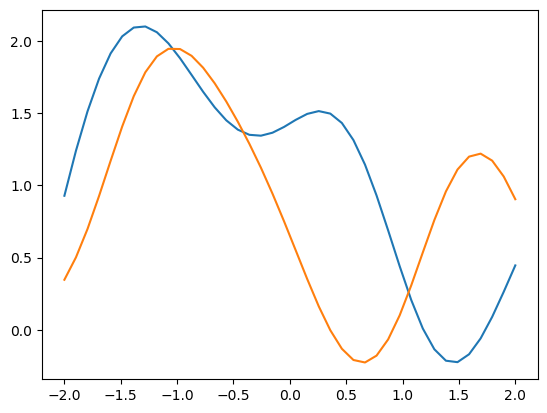

In [31]:
Z1 = sq_ex_emulator.prior.T[:, 0].reshape((nx, nx))
Z2 = sq_ex_emulator.prior.T[:, 1].reshape((nx, nx))

plt.plot(x, sq_ex_emulator.prior.T[:nx, 0])
plt.plot(x, sq_ex_emulator.prior.T[:nx, 1])

plt.show()

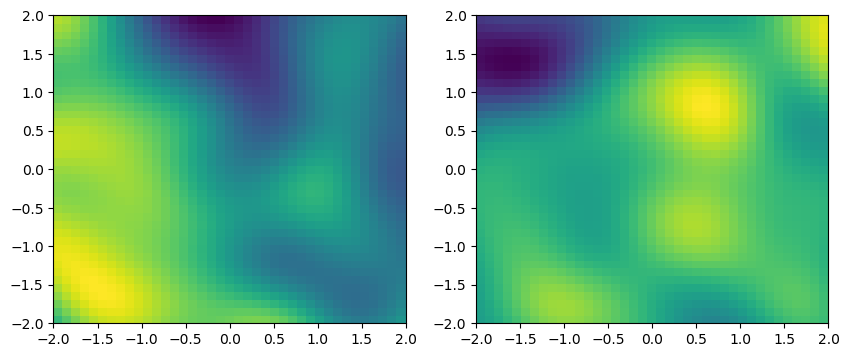

In [32]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].pcolor(x, x, Z1)
ax[1].pcolor(x, x, Z2)
plt.show()

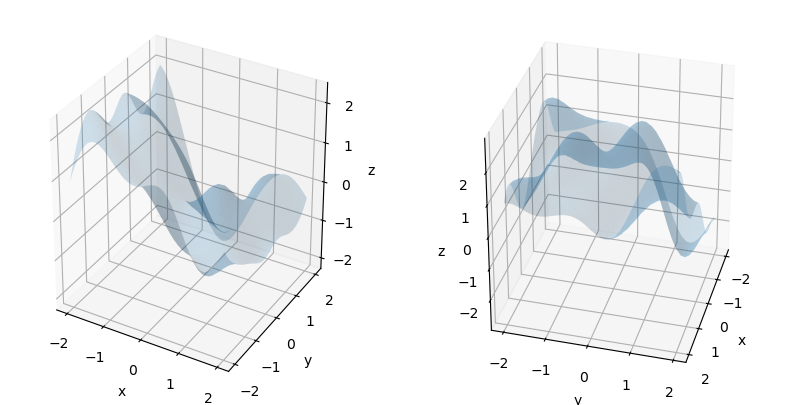

In [33]:
y = np.linspace(-n, n, nx)
xx, yy = np.meshgrid(x, y)
fig3d = plt.figure(figsize=(10, 5))

#first prior
ax3d1 = fig3d.add_subplot(1, 2, 1, projection='3d')
ax3d1.plot_surface(xx, yy, Z1, alpha=0.2)
ax3d1.set_xlabel('x')
ax3d1.set_ylabel('y')
ax3d1.set_zlabel('z')

#second prior
ax3d2 = fig3d.add_subplot(1, 2, 2, projection='3d')
ax3d2.plot_surface(xx, yy, Z2, alpha=0.2)
ax3d2.set_xlabel('x')
ax3d2.set_ylabel('y')
ax3d2.set_zlabel('z')

ax3d1.view_init(None, None)
ax3d2.view_init(None, 15)

plt.show()

## Posterior

In [34]:
X = sampler.sample(nx, n)

X[:, 0] = (X[:, 0] - 0.5) * (2*n)
X[:, 1] = (X[:, 1] - 0.5) * (2*n)

print(X.shape)
print(X.min())
print(X.max())

(40, 2)
-1.8759899505845337
1.9449158636684323


**IMPORTANT** The above method is changing the outcome of the posterior. Before, we were defining X to be based on a set 1D grid, or a call to `np.linspace()`. Now `X` is coming directly from the `LatinHyperCubeSampler`, and I need to investigate why we are getting different samples even though we have specified a random state.

In [35]:
#rosenbrock function
a, b = 1, 100
scaler = 1e3
#y = b*(y-x**2)**2 + (x-a)**2
y = b*(X[:, 1]-X[:, 0]**2)**2 + (X[:, 0]-a)**2
y /= scaler

x = np.linspace(-2, 2, nx)
XX = sq_ex_emulator.expand_grid(x, x)

In [36]:
# training method does not return a value
sq_ex_emulator.train(rosenbrock, X, size=2)

Training Gaussian Process Emulator...


In [37]:
sq_ex_emulator._on_call(XX, y)

Generating posterior estimate...


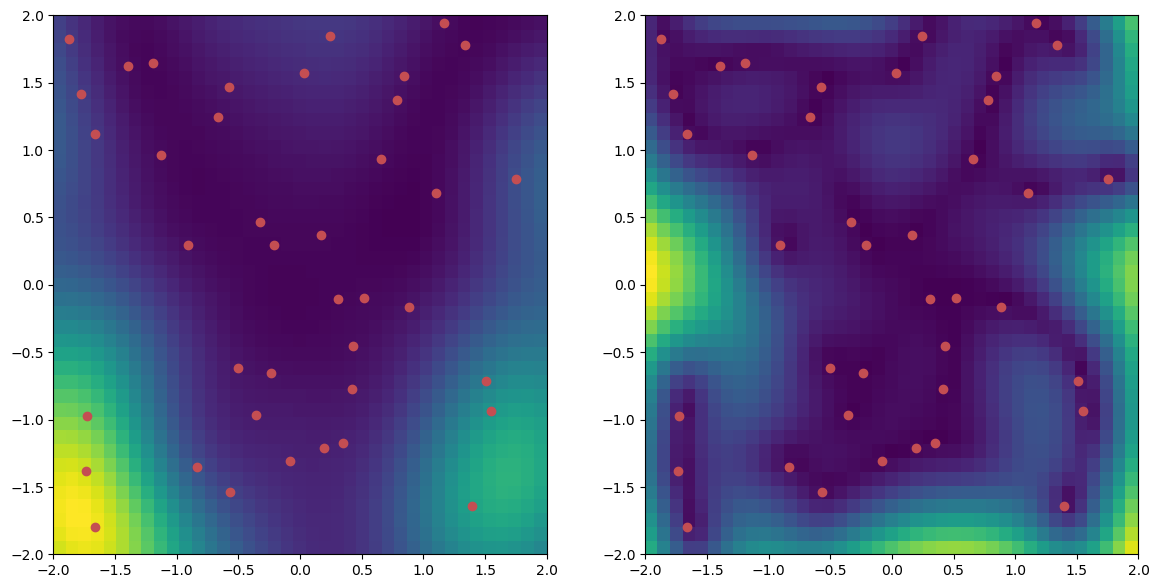

In [38]:
fig, ax = plt.subplots(1, 2, figsize=(14, 7))

ax[0].pcolor(x, x, sq_ex_emulator.mup.reshape((nx, nx)).T)
ax[0].scatter(X[:, 0].T, X[:, 1].T, color='r')

ax[1].pcolor(x, x, sq_ex_emulator.sdp.reshape((nx, nx)).T)
ax[1].scatter(X[:, 0].T, X[:, 1].T, color='r')

ax[0].set_xlim(-n, n)
ax[0].set_ylim(-n, n)

ax[1].set_xlim(-n, n)
ax[1].set_ylim(-n, n)

plt.show()

In [39]:
xx, yy = np.meshgrid(x, x)

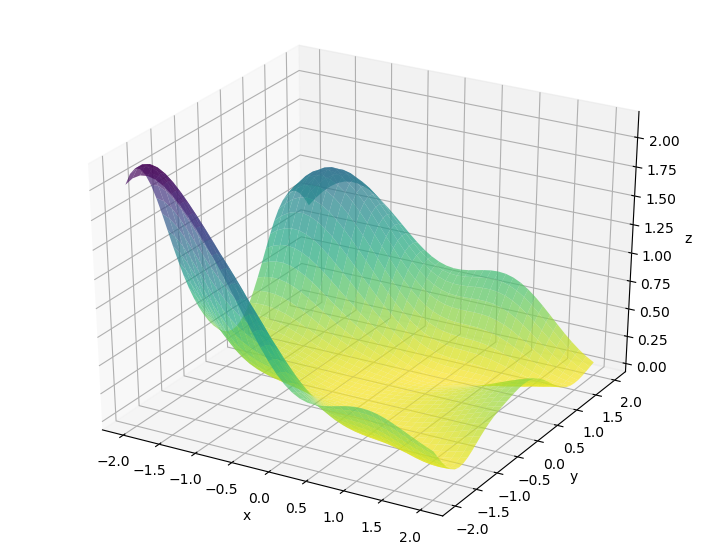

In [40]:
plt.style.use('default')
fig3d = plt.figure(figsize=(9, 7))

#first prior
ax3d = fig3d.add_subplot(projection='3d')
ax3d.plot_surface(xx, yy, sq_ex_emulator.mup.reshape((nx, nx)), alpha=0.7, cmap='viridis_r')

ax3d.set_xlabel('x')
ax3d.set_ylabel('y')
ax3d.set_zlabel('z')

ax3d.view_init(None, -60)

plt.show()

## Gradient-based optimization of GP hyperparameters

### The likelihood function
Multivariate Normal Distribution PDF:
$$ (2 \pi)^\left(-\frac{n}{2}\right) |\Sigma|^\left(-\frac{1}{2}\right) \text{exp}[-\frac{1}{2}(x-\mu)^T \Sigma^{-1}(x-\mu)] $$

In our case:
- $ |\Sigma| = \text{det}(\Sigma) $
- $ (x-\mu) = Y_n $
- $ \Sigma = C_n = \text{exp}[\frac{-|| x - x' ||^2}{\theta^2}] $, although we are also interested in the scale parameter. 

So now we have:
- $ Y_n \sim \mathcal{N}_n(0, \tau^2C_n) $

And we can define the likelihood function as:
$$ L \equiv L(\tau^2, \theta^2, C_n) = (2 \pi \tau^2)^\left( -\frac{n}{2}\right) |\Sigma|^\left(-\frac{1}{2}\right) \text{exp}[-\frac{1}{2 \tau^2}Y_n^T \Sigma^{-1}Y_n] $$

Then the log likelihood $l$ is:
$$ l = \text{ln}(L) = \text{ln}((2 \pi \tau^2)^\left( -\frac{n}{2}\right)) + \text{ln}(|C_n|)^\left(-\frac{1}{2}\right)) -\frac{1}{2 \tau^2}Y_n^T C_n^{-1}Y_n $$

$$ \boxed{l = -\frac{n}{2}\text{ln}(2 \pi) -\frac{n}{2}\text{ln}(\tau^2) - \frac{1}{2}\text{ln}(|C_n|) -\frac{1}{2 \tau^2}Y_n^T C_n^{-1}Y_n} $$

### The gradients
Next, we can look at the gradient of our likelihood function for each of our hyperparameters. Let's look at the scale parameter first.
#### Amplitude scale 
$$ \frac{d}{dx}(\text{ln}(x^2)) = \frac{1}{x^2}*2x = \frac{2}{x} $$

Thus:
$$ \frac{d}{d\tau}(\text{ln}(\tau^2)) = \frac{2}{\tau} $$

And:
$$ \frac{d}{dx}(\frac{1}{x^2}) = \frac{d}{dx}(x^{-2}) = -2x^{-3} = -\frac{2}{x^3} $$

This means that:
$$ \frac{d}{d\tau}(-\frac{1}{\tau^2}) = 2\tau^{-3} = \frac{2}{\tau^3} $$

$$ l'(\tau) = -\frac{n}{2} (\text{ln}(\tau^2))' - \frac{1}{2}\left( \frac{1}{\tau^2} \right)' Y_n^T C_n^{-1} Y_n $$

$$ \boxed{l'(\tau) = -\frac{n}{\tau} + \left( \frac{1}{\tau^3} \right) Y_n^T C_n^{-1} Y_n}$$

#### Length scale
We can do the same thing for the length-scale hyperparameter.
$$ l'(\theta) = (-\frac{1}{2} \text{ln}|C_n|)' - (\left(\frac{1}{2 \tau^2} \right) Y_n^T C_n^{-1} Y_n)' $$

From the *Surrogates* textbook, we get the following handy equations (Eq. 5.9):
$$ \frac{d C_n^{-1}}{d \theta} = - C_n^{-1} \frac{dC_n}{d\theta} C_n^{-1} \text{, and}$$

$$ \frac{d\text{ln}|C_n|}{d\theta} = tr\{C_n^{-1} \frac{dC_n}{d\theta}\} $$

We can derive $\frac{dC_n}{d\theta}$:
$$ \frac{dC_n}{d\theta} = 2C_n \frac{|| x - x' ||^2}{\theta^3} = \frac{2C_n \circ D}{\theta^3}$$

$\circ$ is an element-wise multiplication, and $D$ is our distance matrix from above. Then we can define $\dot{K} = C_n \circ D $, so now we have:
$$ \frac{dC_n}{d\theta} = \frac{2\dot{K}}{\theta^2} $$ 

From there, we can finish deriving $l'(\theta)$ further by substituting in the terms we found above:
$$ \boxed{l'(\theta) = -\frac{1}{2} tr\{C_n^{-1} \frac{2\dot{K}}{\theta^3}\} + \left(\frac{1}{2 \tau^2} \right) Y_n^T C_n^{-1} \left( \frac{2\dot{K}}{\theta^3} \right) C_n^{-1} Y_n} $$

In [41]:
nlist = 30
min_bound = 10**-4
length = (x.max() - x.min())

tau_list = np.geomspace(min_bound, length, nlist)
theta_list = np.geomspace(min_bound, length, nlist)
gridx, gridy = np.meshgrid(tau_list, theta_list)

ll_values = np.array([sq_ex_emulator._ll([], scale=tau, length_scale=theta) for tau in tau_list for theta in theta_list])
ll_grid = ll_values.reshape(nlist, nlist)

We can plot a grid of the log likelihood as a function of our hyperparameters below.

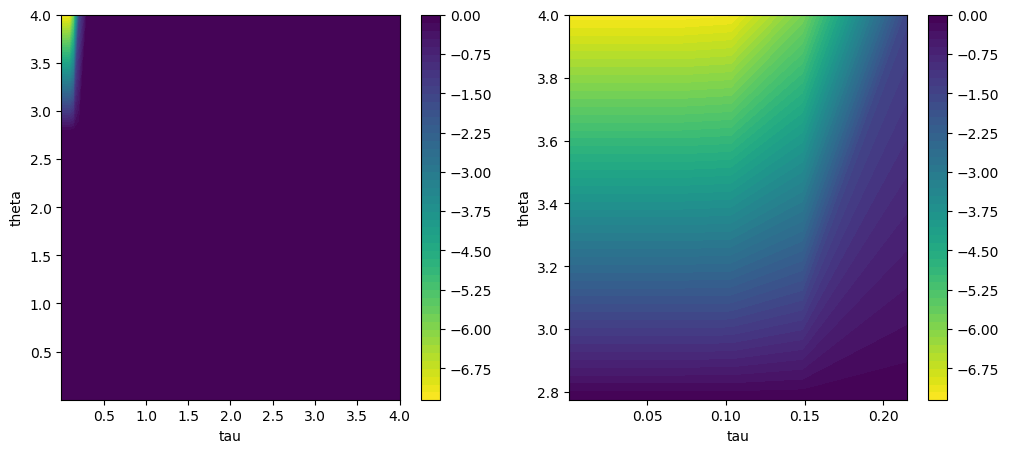

In [42]:
zoomx = 22
zoomy = 28
scaler = 1e47
gridx, gridy = np.meshgrid(tau_list, theta_list)
plot_params = {'cmap': 'viridis_r', 'levels': 50}

fig, ax = plt.subplots(1, 2, figsize=(12, 5))
contours = ax[0].contourf(gridx, gridy, ll_grid/scaler, **plot_params)
contours_zoom = ax[1].contourf(tau_list[:zoomx], theta_list[zoomy:], ll_grid[zoomy:, :zoomx]/scaler, **plot_params)

fig.colorbar(contours, ax=ax[0])
fig.colorbar(contours_zoom, ax=ax[1])

ax[0].set_xlabel('tau')
ax[0].set_ylabel('theta')

ax[1].set_xlabel('tau')
ax[1].set_ylabel('theta')

plt.show()

Now we can use our `minimize()` method to see where the best hyperparameters are.

In [43]:
x0 = [0, 3]
bounds = [(min_bound, length) for element in x0]
result = sq_ex_emulator.optimize(x0, bounds)

In [44]:
result

      fun: array([-2.93473164e+16])
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([[ 5.86946327e+20],
       [-1.76868234e+15]])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 2
      nit: 1
   status: 0
  success: True
        x: array([1.e-04, 4.e+00])

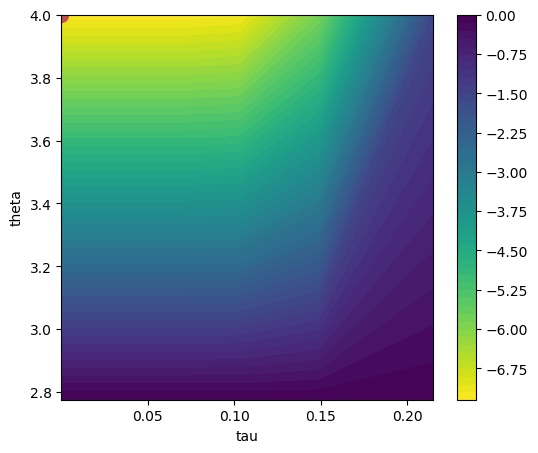

In [45]:
fig, ax = plt.subplots(figsize=(6, 5))
contours_zoom = ax.contourf(tau_list[:zoomx], theta_list[zoomy:], ll_grid[zoomy:, :zoomx]/scaler, **plot_params)
ax.scatter(result.x[0], result.x[1], color='r', marker='o', s=100)

fig.colorbar(contours_zoom, ax=ax)
ax.set_xlabel('tau')
ax.set_ylabel('theta')
ax.set_xlim([tau_list[:zoomx].min(), tau_list[:zoomx].max()])
ax.set_ylim([theta_list[zoomy:].min(), theta_list[zoomy:].max()])

plt.show()

In [46]:
dtau, dtheta = sq_ex_emulator._ll_prime([])
print('dtau:', dtau)
print('dtheta: ', dtheta)

dtau: [-29.37008162]
dtheta:  [77.93637313]


In [47]:
result = sq_ex_emulator.optimize(x0, bounds, jacobian=True)
result

      fun: array([-2.93473164e+16])
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 6.98161762e+20, -1.76868280e+15])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 6
      nit: 1
   status: 0
  success: True
        x: array([1.e-04, 4.e+00])

## Finding the minimum of our GP Emulator's posterior.

We just found the optimal hyperparameters the first time we ran `scipy.optimize.minimize()`, where using the Jacobian is optional. Let's find the minimum of our posterior of the Rosenbrock function with the optimal hyperparameters.

In [48]:
# optimal hyperparameters
s, l = result.x[0], result.x[1]
print(s, l)

0.0001 4.0


In [49]:
# update gp emulator with optimal hyperparams
sq_ex_emulator._on_call(XX, y, update=True, scale=s, length_scale=l)

Generating posterior estimate...


Below, we can see how well our Gaussian Process Emulator does at replicating the Rosebrock function.

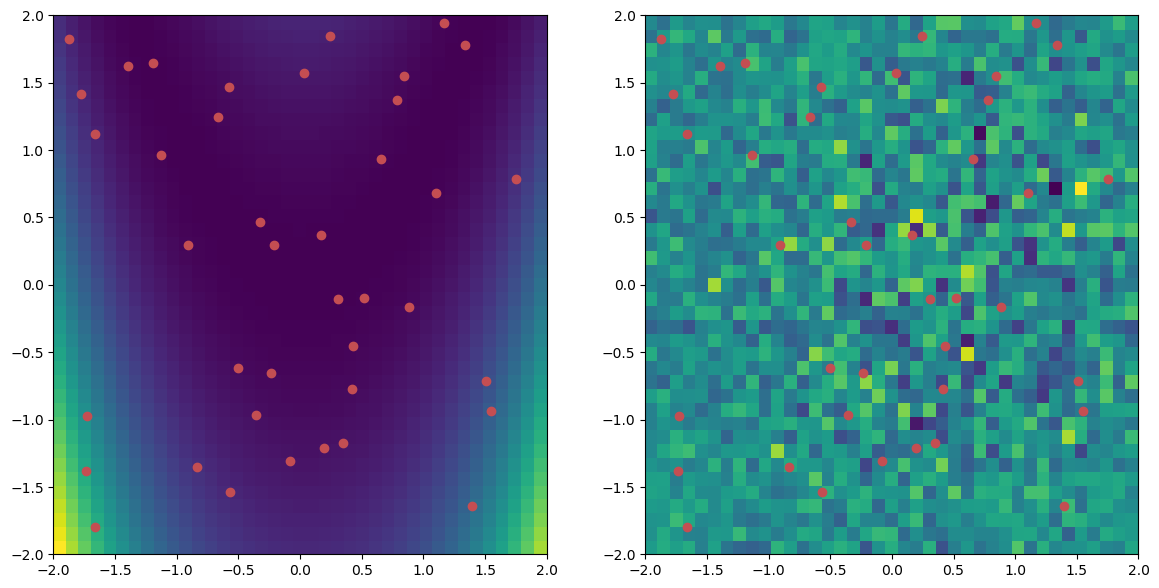

In [50]:
fig, ax = plt.subplots(1, 2, figsize=(14, 7))

ax[0].pcolor(x, x, sq_ex_emulator.mup.reshape((nx, nx)).T)
ax[0].scatter(X[:, 0].T, X[:, 1].T, color='r')

ax[1].pcolor(x, x, sq_ex_emulator.sdp.reshape((nx, nx)).T)
ax[1].scatter(X[:, 0].T, X[:, 1].T, color='r')

ax[0].set_xlim(-n, n)
ax[0].set_ylim(-n, n)

ax[1].set_xlim(-n, n)
ax[1].set_ylim(-n, n)

plt.show()

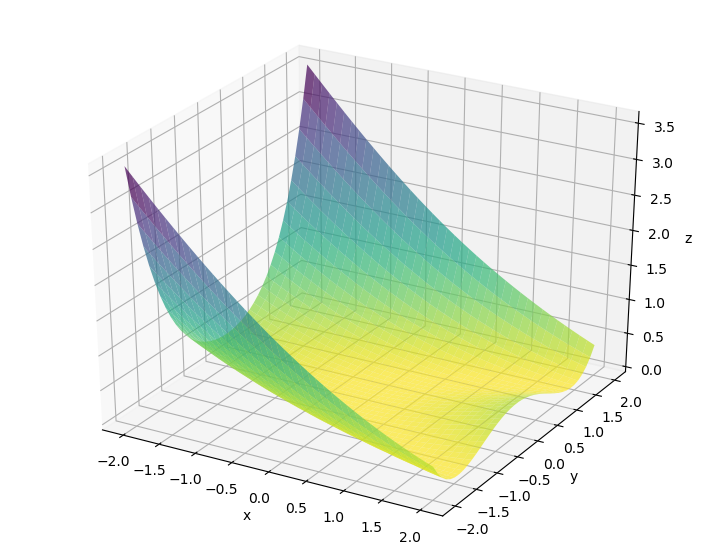

In [51]:
plt.style.use('default')
fig3d = plt.figure(figsize=(9, 7))

#first prior
ax3d = fig3d.add_subplot(projection='3d')
ax3d.plot_surface(xx, yy, sq_ex_emulator.mup.reshape((nx, nx)), alpha=0.7, cmap='viridis_r')

ax3d.set_xlabel('x')
ax3d.set_ylabel('y')
ax3d.set_zlabel('z')

ax3d.view_init(None, -60)

plt.show()

This looks great! But looks can be deceiving. How truly far off is our estimate?

In [52]:
z = sq_ex_emulator.mup.reshape((nx, nx))
zmin = np.min(z)
zargmin = np.where(z==zmin)[0][0]

#we expect to see 1, 1
xmin, ymin = xx[zargmin, zargmin], yy[zargmin, zargmin]
minima_posterior = np.round([xmin, ymin, zmin], 6)

print(minima)
print(minima_posterior)

[1.0, 1.0, 0.0]
[ 1.384615e+00  1.384615e+00 -2.400000e-04]


In [53]:
np.set_printoptions(suppress=True)

print('Posterior estimate of Rosenbrock minimum: {}'.format(minima_posterior[-1]))
print('True minimum of the Rosenbrock function: {}'.format(minima[-1]), '\n')

print('X and y axes should have minimum at: [{}, {}].'.format(minima[0], minima[1]))
print('Estimate of values: [{}, {}]'.format(minima_posterior[0], minima_posterior[1]), '\n')

print('Difference between true minimum and estimate: {}'.format(minima-minima_posterior))
print('RMSE between true minimum and estimate: {}'.format(np.round(np.sqrt(np.mean((minima-minima_posterior)**2)), 6)))

Posterior estimate of Rosenbrock minimum: -0.00024
True minimum of the Rosenbrock function: 0.0 

X and y axes should have minimum at: [1.0, 1.0].
Estimate of values: [1.384615, 1.384615] 

Difference between true minimum and estimate: [-0.384615 -0.384615  0.00024 ]
RMSE between true minimum and estimate: 0.314037


The emulator is doing a very good job of replicating the general shape of the function. However, one reason the Rosenbrock function is popular in optimization problems is because of it's unique shape: the function creates a surface with a long, curved trough at the bottom. The true minimum is to the left, so a good emulator/optimizer will not get stuck in the trough where there are plenty of local minima.

A note about the plot below: when plotting the actual Rosenbrock function minimum at the start of this Notebook, I had the point [2, 2] in the bottom left-hand corner. So I inverted the x and y axis to match this. As you can see, the minimum is still on the left side of the trough.

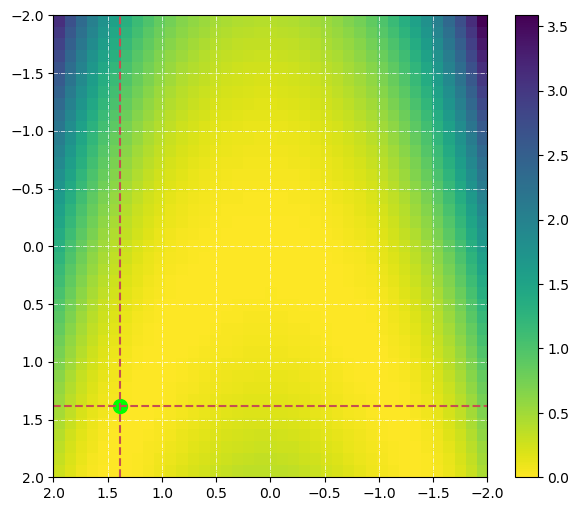

In [54]:
fig, ax = plt.subplots(figsize=(7, 6))

posterior = ax.pcolor(xx.T, yy.T, z, cmap='viridis_r')
ax.scatter(xmin, ymin, s=100, c='lime', alpha=1)
ax.axhline(y=ymin, color='r', linestyle='--')
ax.axvline(x=xmin, color='r', linestyle='--')

ax.grid(which='both', color='white', ls = '-.', lw = 0.5)
fig.colorbar(posterior)

plt.gca().invert_xaxis()
plt.gca().invert_yaxis()

plt.show()

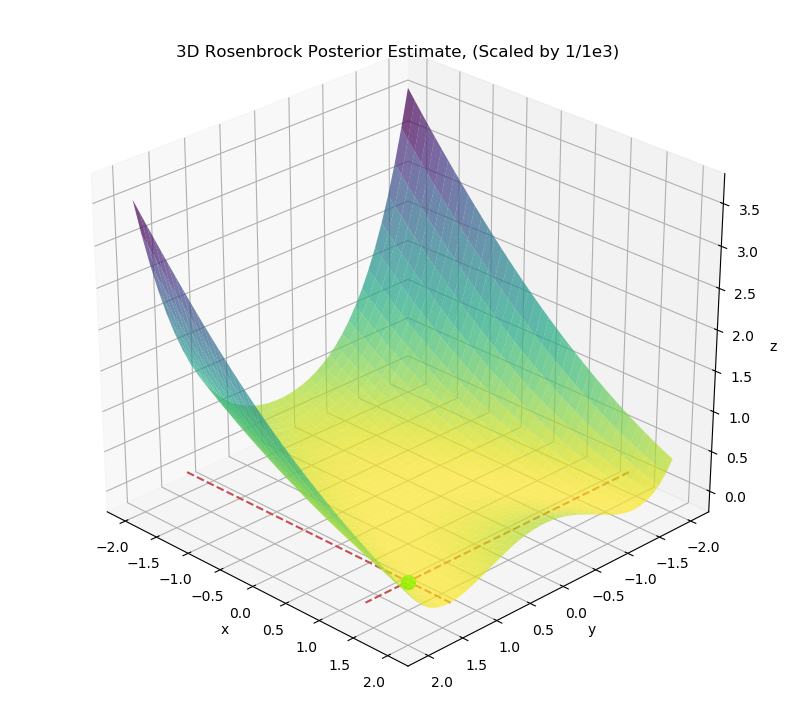

In [57]:
X0 = np.where(xx == xmin)
Y0 = np.where(yy == ymin)

plt.style.use('default')
fig3d = plt.figure(figsize=(10, 9))

#first prior
ax3d = fig3d.add_subplot(projection='3d')
ax3d.plot_surface(xx, yy, z, alpha=0.7, cmap='viridis_r')
ax3d.scatter(xmin, ymin, zmin, c='lime', s=100, alpha=1)

ax3d.plot(xx[X0], yy[X0], color='r', linestyle='--')
ax3d.plot(xx[Y0], yy[Y0], color='r', linestyle='--')

ax3d.set_xlabel('x')
ax3d.set_ylabel('y')
ax3d.set_zlabel('z')
ax3d.set_title('3D Rosenbrock Posterior Estimate, (Scaled by 1/1e3)')

ax3d.invert_xaxis()
ax3d.view_init(None, 135)

#plt.savefig('./images/gp_emulator_rosenbrock.png', format='png', bbox_inches='tight')

plt.show()

**Citations**:
- Momin Jamil and Xin-She Yang, A literature survey of benchmark functions for global optimization problems, Int. Journal of Mathematical Modelling and Numerical Optimisation, Vol. 4, No. 2, pp. 150–194 (2013).
DOI: 10.1504/IJMMNO.2013.055204

-  H. H. Rosenbrock, “An Automatic Method for Finding the Greatest or least Value of a Function,” Computer Journal, vol. 3, no. 3, pp. 175-184, 1960. [Available Online]: http://comjnl.oxfordjournals.org/content/3/3/175.full.pdf

- M. D. McKay , R. J. Beckman & W. J. Conover (1979) Comparison of Three Methods for Selecting Values of Input Variables in the Analysis of Output from a Computer Code, Technometrics, 21:2, 239-245, DOI: 10.1080/00401706.1979.10489755